<a href="https://colab.research.google.com/github/arjunjyothieswarb/CS5180/blob/main/Assignment5/ex5_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 4 and 5 Windy Gridworld Domain

In [90]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [91]:
class WindyGridWorld(object):
    def __init__(self, enable_king_move=False, enable_no_move=False):
        # define the grid space
        self.grid = np.zeros((7, 10))

        # define the state space
        self.state_space = [[r, c] for r, c in zip(np.where(self.grid == 0.0)[0],
                                                   np.where(self.grid == 0.0)[1])]

        # define the start state
        self.start_state = [3, 0]

        # define the goal state
        self.goal_state = [3, 7]

        # define the wind
        self.wind = np.array([0, 0, 0, 1, 1, 1, 2, 2, 1, 0], dtype=int)

        # define the action space
        self.action_space = {
            "up": np.array([-1, 0]),
            "down": np.array([1, 0]),
            "left": np.array([0, -1]),
            "right": np.array([0, 1])
        }

        # Enable King's moves (Comment out the above action space to create a new one for King's moves)
        # if enable_king_move:

        #     if enable_no_move:
        #         #TODO
        #     else:
        #         #TODO
        #
        # else:
        #     #TODO


        # track the current state, time step, and action
        self.state = None
        self.t = None
        self.act = None


    def reset(self):
        # reset the agent to the start state
        self.state = self.start_state[:]
        # reset the time step tracker
        self.t = 0
        # reset the action tracker
        self.act = None
        # reset the terminal flag
        terminated = False
        return self.state, terminated

    def step(self, act):

        #TODO
        terminated = False

        # Getting the action
        action = np.array(self.action_space[act])

        # Updating the state
        state = np.array(self.state)
        state[0] += action[0] - self.wind[state[1]]
        state[1] += action[1]

        # Clipping the state values
        state[0] = np.clip(state[0], 0, 6)
        state[1] = np.clip(state[1], 0, 9)

        self.state = state.tolist()

        # Checking if the agent has reached the goal state
        if self.state == self.goal_state:
            reward = 0
            terminated = True
        else:
            reward = -1

        self.t += 1
        self.act = act
        # print("Next State: ",self.state, "\n----")
        return self.state, reward, terminated

    def next_state(self, state, act):

        # Getting the action
        action = self.action_space[act]
        new_state = np.array(state)

        # Updating the state
        new_state[0] += action[0] - self.wind[new_state[1]]
        new_state[1] += action[1]

        # Clipping the state values
        new_state[0] = min(new_state[0], 6)
        new_state[0] = max(new_state[0], 0)

        new_state[1] = min(new_state[1], 9)
        new_state[1] = max(new_state[1], 0)

        return new_state.tolist()

    def render(self):
        # plot the agent and the goal
        # agent = 1
        # goal = 2
        plot_arr = self.grid.copy()
        plot_arr[self.state[0], self.state[1]] = 1.0
        plot_arr[self.goal_state[0], self.goal_state[1]] = 2.0
        plt.clf()
        fig, arr = plt.subplots(1, 1)
        arr.set_title(f"state={self.state}, act={self.act}")
        arr.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(1)
        plt.close(fig)


In [102]:
# @title SARSA
class SARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

        # define action_space_index
        self.action_keys = list(self.env.action_space.keys())

        # define the action_key_index
        self.action_key_index = {"up":0, "down":1, "left":2, "right":3, "up-left":4, "up-right":5, "down-left":6, "down-right":7, "freeze":8}

        self.episodes = np.zeros(self.timeout)

    def behavior_policy(self, state):
        #TODO

        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_keys[0:self.action_num])
        else:
            # max_indices = np.argwhere(self.Q[state,:] == np.max(self.Q[state,:]))
            # action_index = np.random.choice(max_indices.T[0])
            state_index = (state[0] * 10) + state[1]
            action_index = np.argmax(self.Q[state_index,:])
            action = self.action_keys[action_index]

        return action

    def update(self, s, a, r, s_prime, a_prime):
        #TODO

        # Getting the indices of states
        state_index = (s[0] * 10) + s[1]
        state_prime_index = (s_prime[0] * 10) + s_prime[1]

        # Getting action indices
        action_index = self.action_key_index[a]
        action_prime_index = self.action_key_index[a_prime]

        # Updating using SARSA
        self.Q[state_index, action_index] += self.alpha * (r + (self.gamma * self.Q[state_prime_index, action_prime_index]) - self.Q[state_index, action_index])

        return None

    def rollout(self):

        # Resetting the env
        state, terminated = self.env.reset()

        # Getting action
        action = self.behavior_policy(state)

        cum_episodes = 0

        t = 0
        while(t < self.timeout):

            if terminated:
                cum_episodes += 1
                state, terminated = self.env.reset()
                action = self.behavior_policy(state)

            # Taking the step
            state_prime, reward, terminated = self.env.step(action)
            # print(state, state_prime, action)

            # Get the next action
            action_prime = self.behavior_policy(state_prime)

            # Updating the Q-table
            self.update(state, action, reward, state_prime, action_prime)

            # Updating the state and action
            state[0] = state_prime[0]
            state[1] = state_prime[1]

            action = action_prime

            self.episodes[t] = cum_episodes
            t += 1


        return None

    def run(self):
        #TODO
        self.rollout()

        return self.episodes

In [93]:
# @title ExpectedSARSA
class ExpectedSARSA(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        #TODO
        return None

    def update(self, s, a, r, s_prime, a_prime):
        #TODO
        return None

    def rollout(self):
        pass

    def run(self):
        #TODO
        return None

In [94]:
# @title QLearning
class QLearning(object):
    def __init__(self, env, alpha, epsilon, gamma, timeout):
        # define the parameters
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma

        # environment
        self.env = env

        # define the Q value table
        self.state_num = len(self.env.state_space)
        self.action_num = len(self.env.action_space.keys())
        self.Q = np.zeros((self.state_num, self.action_num))

        # define the timeout
        self.timeout = timeout

    def behavior_policy(self, state):
        #TODO
        return None

    def update(self, s, a, r, s_prime):
        #TODO
        return None

    def rollout(self):
        pass

    def run(self):
        #TODO
        return None

In [95]:
# @title Plot func
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

    Make sure the elements in the arr_list, legend_list, and color_list are associated with each other correctly.
    Do not forget to change the ylabel for different plots.
    """
    # Clear the current figure
    plt.clf()
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set labels
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the mean and standard error while ignoring NaN values
        mean_arr = np.nanmean(arr, axis=0)
        arr_err = np.nanstd(arr, axis=0) / np.sqrt(np.sum(~np.isnan(arr), axis=0))

        # Plot the mean
        h, = ax.plot(range(len(mean_arr)), mean_arr, color=color, label=legend)

        # Plot the confidence band
        arr_err = 1.96 * arr_err  # 95% confidence interval
        ax.fill_between(range(len(mean_arr)),
                        mean_arr - arr_err,
                        mean_arr + arr_err,
                        alpha=0.3, color=color)
        # Save the plot handle
        h_list.append(h)

    # Set the title (adjust as needed)
    ax.set_title("Windy Gridworld Results")
    ax.legend(handles=h_list)
    plt.show()

In [96]:
# @title run_on_policy_td_control
def run_on_policy_td_control(run_num, timeout):

    enable_king_move_actions = False
    enable_no_move_actions = False

    # create the environment
    env = WindyGridWorld(enable_king_move=enable_king_move_actions, enable_no_move=enable_no_move_actions)

    # parameters
    epsilon = 0.1
    alpha = 0.5
    gamma = 1.0
    """
    # create the expected SARSA
    expected_sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_expected_sarsa = ExpectedSARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_expected_sarsa.run()
        # append the results
        expected_sarsa_results_list.append(episodes[0:8000])
    """
    # create the SARSA
    sarsa_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_sarsa = SARSA(env, alpha, epsilon, gamma, timeout)
        episodes = controller_sarsa.run()
        # append the results
        sarsa_results_list.append(episodes[0:8000])
        print("Run %d completed!", _)
    """
    # create the Q learning
    q_learning_results_list = []
    for _ in range(run_num):
        # run for each trial
        controller_q_learning = QLearning(env, alpha, epsilon, gamma, timeout)
        episodes = controller_q_learning.run()
        # append the results
        q_learning_results_list.append(episodes[0:8000])
    """
    sarsa_array = np.array(sarsa_results_list)
    # expected_sarsa_array = np.array(expected_sarsa_results_list)
    # q_learning_array = np.array(q_learning_results_list)

    # Plot the results
    # plot_curves(
        # [sarsa_array, expected_sarsa_array, q_learning_array],
        # ['SARSA', 'Expected SARSA', 'Q-learning'],
        # ['r', 'b', 'g'],
        # "Episodes"
    # )

    plot_curves(
        [sarsa_array],
        ['SARSA'],
        ['r'],
        "Episodes"
    )

Run %d completed! 0


<Figure size 640x480 with 0 Axes>

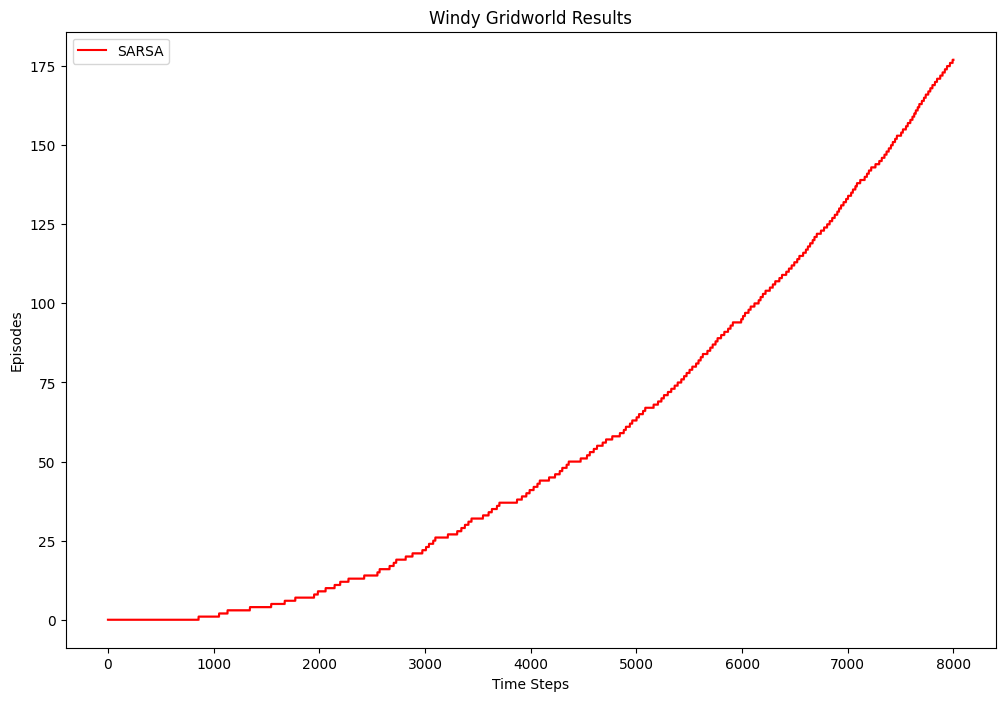

In [103]:
if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # trial number
    trial_num = 1
    # trial_num = 10
    # maximal time steps
    max_time_steps = 8000
    # max_time_steps = 8000


    # run SARSA and Q Learning
    run_on_policy_td_control(trial_num, max_time_steps)

# Question 5 [5180 ONLY]
- Please refer to starter code from question 4 to help you get started. You will create your own TD(0) and Monte Carlo classes.
- We will continue with the original windy gridworld domain.
- A fixed policy π will be specified to collect episodes.
- A certain number of “training” episodes N ∈ {1, 10, 50} will be collected.
- Each method being investigated ( On-policy TD(0), On-policy Monte-Carlo prediction) will learn to      estimate the state-value.
function using the N “training“ episodes, respectively.
- We then evaluate the distribution of learning targets each method experiences at a specified state S. In
this question, S is the initial state marked as S in the Example 6.5.
- To do so, you need to collect additional 100 “evaluation” episodes. Instead of using these to perform
further updates to the state-value function, we will instead evaluate the distribution of learning targets
V(S) based on the “evaluation” episodes. For example, TD(0) will experience a set of {R+ V(S′)} targets,
whereas Monte-Carlo will experience a set of {G} targets.
- Note that in practice you should pre-collect both the training and evaluation episodes for efficiency and to
ensure consistency while comparing between different methods.

In [ ]:
def run_on_policy_mc_td_epsilon_greedy_windy_gridworld():
    enable_king_move_actions = False
    enable_no_move_actions = False

    # create environments
    env = WindyGridWorld(enable_king_move=enable_king_move_actions,
                         enable_no_move=enable_no_move_actions)
    env.reset()

In [ ]:
if __name__ == "__main__":
    # set randomness
    np.random.seed(1234)
    random.seed(1234)

    # run Monte Carlo and TD(0) for Question 6. Modify as necessary
    run_on_policy_mc_td_epsilon_greedy_windy_gridworld()